### Blockchain project #2
This file will be our main file for this project. 
Lets explain our process here
First start of with creating block and blockchain class.
We need to force a fork such that the smaller fork can be the uncle
implement reward.


### Tasks: 
- model a blockchain that uses uncle and uncle rewards
- model a rewarding mechanism to reward uncle block creators
- model selfish mining (only one attacker) in this blockchain

### Answer the following questions: 
- How do uncles improve the fairness of the blockchain? For this, you should compare the outcome of miners with and without uncles

Miners with lower miningpower, that in a normal situation would be unable to gain a block. They will now with the uncle reward get rewards event thought their block was not used. This makes it so that the miningpower used for the uncle block will not all be wasted. 

*** 

- What is the impact of the uncles on selfish mining? Is selfish mining more profitable with uncles?

It makes it more profitable for selfish miners, because the risk in selfish mining is that sets you at risk of losing everything. While with uncles the selfish miners will receive almost full reward, thus selfish mining is much less risky. Yes, much more.

***

- What does it mean in this model for the selfish mining attack to be profitable?

If a selfish miner mines a block, and is not chosen to be in the longest chain. Normally the block is discarded without any reward. However with uncles, the selfish mined block will receive reward for using resources to mine a block. Therefore the selfish miner, will receive reward either if he succeeds in creating an accepted block or not. Thus selfish mining will always be "worth the power". 

Start off with declearing block, miner and blockchain:

In [171]:
#import statements
from IPython.display import HTML, display
import hashlib as hasher
import random
import pandas as pd
import matplotlib.pyplot as plt

BASEREWARD = 10 #Base reward
UNCLEREWARD = 5 #Base uncle reward
NEPHEWREWARD = 2 #Base nephew reward
def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def hash(input):
    hash_obj = hasher.sha256()
    inputbytes = input.decode()
    hash_obj.update(inputbytes)
    return hash_obj.hexdigest()

def numberOfInitZeros(hashStr):
    count = 0
    for i in range(0, len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block: 
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0, "0")
            self.height = 0
            
        else: 
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []
    
    def hash_block(self):
        return hashbits(self.data+self.creator.name+self.previous_hash+str(self.nonce))

    def print(self):
        print(self.data+" "+self.creator.name+" "+str(self.height))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.forked = []
        self.mainchain = []
        self.mainchainPrint = []
        self.uncles = []
        self.uncleBlocks = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
    
    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        r = random.choices(maxes, k=1)
        return r[0]
    
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size += 1

    def print(self):
        for block in self.chain:
            block.print()
            print("______")

    def hasFork(self): #This checks if the chain has a fork        
        for block1 in self.chain:
            for block2 in self.chain:
                if block1 != block2 and block1.height == block2.height:
                    return True
        return False

    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last != None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

    def createMainChain(self):
        lb = self.longestChain()
        while lb.previous != None or lb.height ==0:
            self.mainchain.append(lb)
            self.mainchainPrint.append(lb.creator.name)
            if lb.height == 0:
                break
            lb = lb.previous
 
    def getUncles(self): #Append blocks that are not in mainchain to uncle list
        for block in self.chain:
            if block not in self.mainchain:
                self.uncles.append(block.creator.name)
    def getUnclesBlock(self):
        for block in self.chain:
            if block not in self.mainchain:
                self.uncleBlocks.append(block)
   
def bitToHex(bitBlock):
    return hex(int(bitBlock,2))

class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.reward = 0 # added reward attribute
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.MinedLastBlock = False
        self.blockchain = blockchain
        self.coins = []
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()

    
    def UpdateLast(self):
        latest = self.blockchain.longestChain()             
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
         
    
    def PoWSolver(self):
        for i in range(0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
                self.MinedLastBlock = True
            self.nonce += 1




In [172]:
class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        #self.nonce = random.randint(0,100000)
        self.reward = 0
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height: 
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height -1 and len(self.privateBlocks) > 1:
            for block in self.privateBlocks: 
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True

    def PoWSolver(self):
        for i in range (0, self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else: 
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

def attackerHasControl(blockchain, attacker):
    if blockchain.longestChain().creator == attacker: 
        return True
    return False

In [173]:
#Drawing the blockchain
def maxHeight(parent):
  if len(parent.children) == 0:
    return parent.height 
  max = 0
  for child in parent.children:
    m = maxHeight(child)
    if m> max:
      max = m
  return max
  

def drawBlockchain(parent, level, html, parentLevel, childN = 0, total = 0):
  color = "#AEF751"
  if parentLevel!=-1:
    color = "#7EDBF6"
  elif type(parent.creator) is SelfishMiner:
      color = "#F59AEE"
  parent.children.sort(key=lambda x: (maxHeight(x)), reverse=True)
  xx = childN
  level += childN
  html += '<g>'
  html += '<rect x="'+str(30+ 100*parent.height)+'" y="'+str(30+ 100*level)+'" width="60" height="60" stroke="black" stroke-width="1" fill="'+color+'" />'
  html += '<text x="'+str((60+ 100*parent.height))+'" y="'+str((60+ 100*level))+'" dominant-baseline="middle" text-anchor="middle" font-family="Verdana" font-size="10" font-weight="bold" fill="black">'+str(parent.creator.name)+'</text>'
  if parentLevel != -1:
    if (parent.previous.children.index(parent)) == 0:
      html += '<line stroke-width="1px" stroke="#000000"  x1='+str(30+ 100*parent.height)+' y1="'+str(60+ 100*level)+'" x2="'+str(95+ 100*parent.previous.height)+'" y2="'+str(60+ 100*parentLevel)+'" style="marker-end: url(#markerArrow)"/>'
    else:
      html += '<line stroke-width="1px" stroke="#000000"  x1='+str(30+ 100*parent.height)+' y1="'+str(60+ 100*level)+'" x2="'+str(65+ 100*parent.previous.height)+'" y2="'+str(95+ 100*parentLevel)+'" style="marker-end: url(#markerArrow)"/>'
  html += '</g>'
  l = level
  childN = 0
  for child in parent.children:
    html,n, t = drawBlockchain(child, l, html, level, childN, total)
    if n > 0:
      childN += n
    if t > 0:
      total += t
    l = l+1
  return html, childN+ len(parent.children)-1, total+ len(parent.children)-1


def show(bc):
  htmll = ""
  html = ""
  htmll, n, t = drawBlockchain(bc.chain[0], 0, html, -1)
  html = '<svg height="'+str(115*(n+1))+'" width="'+str(115*maxHeight(bc.chain[0]))+'">'
  html += '<defs><marker id="markerArrow" markerWidth="10" markerHeight="10" refX="2" refY="6" orient="auto"><path d="M2,2 L2,11 L10,6 L2,2" style="fill: #000000;" /> </marker> </defs>'
  html += htmll
  html += '</svg>'
  display(HTML(html))

In [185]:
# a simple function calculating base rewards not worrying about uncle
def calculateBaseRewards(miners, mainchain):
  for minerName in mainchain:
    for miner in miners: 
      if miner.name == minerName:
        miner.coins.append(BASEREWARD)
        miner.reward += BASEREWARD

# calculating unclerewards
def calculateUncleRewards(miners, uncleChain, mainchain):
  
  for block in uncleChain:  
    minerName = block.creator.name 
    height = block.height 
    for mainBlock in mainchain:
      if mainBlock.height == height:
        nephewName = mainBlock.creator.name

    for miner in miners: 
      if miner.name == minerName:
        miner.coins.append(UNCLEREWARD)
        miner.reward += UNCLEREWARD
      
      if miner.name == nephewName:
        miner.coins.append(NEPHEWREWARD)
        miner.reward += NEPHEWREWARD
  

def showRewards(miners):
  for m in miners:
    print(m.name," earned: ", m.reward," coins")

def visualizeRewards(miners, withOrWithout):
  names = []
  coins = []
  for m in miners:
    names.append(m.name)
    coins.append(m.reward)

  plotdata = pd.DataFrame({"coins": coins}, index= names)
  average=  sum(coins)/len(coins)
  s = "Coins rewarded "+ withOrWithout+ " uncle reward : "+ str(sum(coins))+" average: " + str(average)  
 # plotdata.append(plotdata.mean())
  plotdata.plot(kind="bar", xlabel= "miners", ylabel="reward", title= s)

  ## Trying to plot lines of coins
def visualizeLines(miners):
  allCoins = []
  c = 0
  for m in miners:
    c+=1
    if c == 1 or c == 2 or c == 14 or c == 15:
      allCoins.append(m.coins)

  x = [1,2,3,4]
  y = allCoins
  plt.xlabel("Time/Rounds")
  plt.ylabel("Money")
  plt.title("Evolution of coins")
  print(x, y)
  for i in range(len(y[0])):
    plt.plot(x, [pt[i] for pt in y], label="miner %s"%i)
  plt.legend()
  plt.show()


## Modelling blockchain with uncle reward

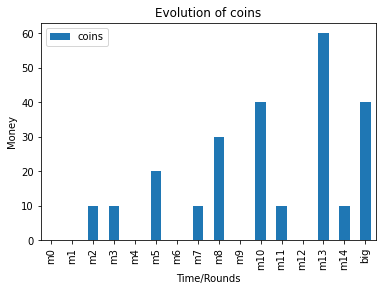

IndexError: list index out of range

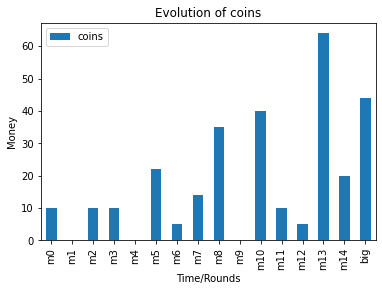

In [175]:
#Declearing blockchain and printing properties
bc = Blockchain("0", 5)
miners = []
for i in range(15):
    m = Miner(1, "m"+str(i), bc)
    miners.append(m)

big = Miner(5, "big", bc)
while bc.size < 31:
    big.PoWSolver()

    for m in miners:
        m.PoWSolver()

    big.UpdateLast()
    
    for m in miners:
        m.UpdateLast()
#appended to calculate rewards
miners.append(big)
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
calculateBaseRewards(miners,bc.mainchainPrint)
visualizeRewards(miners, "without")
calculateUncleRewards(miners, bc.uncleBlocks, bc.mainchain)
visualizeRewards(miners, "with")


In [ ]:
show(bc)

## Modelling blockchain with selfish miner and uncle rewards

alpha 0.10526315789473684
[1, 2, 3, 4] [[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2], [10, 10, 10, 10, 10, 10, 2, 5, 5, 5, 5, 5], [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 2, 5, 5, 5, 5, 2, 5, 5, 2, 2, 5, 5], [10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 5, 5, 5, 2, 5, 5, 2, 5, 2]]


IndexError: list index out of range

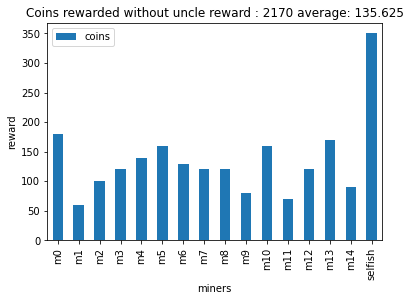

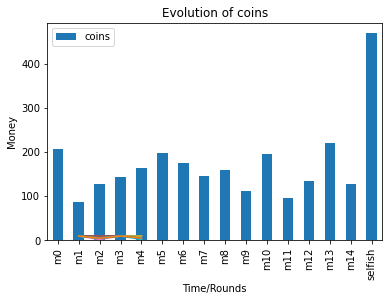

In [186]:

bc = Blockchain("0", 5)
miners = []
for i in range(15):
    m = Miner(1, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(2,"selfish", bc)
while bc.size < 300:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
calculateBaseRewards(miners,bc.mainchainPrint)
visualizeRewards(miners, "without")
calculateUncleRewards(miners, bc.uncleBlocks, bc.mainchain)
visualizeRewards(miners, "with")
visualizeLines(miners)


In [ ]:
show(bc)

## Plotting wrong values (Uncle+Neph > BlockReward)


alpha 0.10526315789473684
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 3, 3, 3, 10, 3, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 10, 10, 10, 10, 10, 3, 3, 10, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 10, 3, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 10, 3, 10, 3, 3, 3, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 10, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 10, 10, 3, 10, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 3, 3, 10, 10, 10, 10, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 10, 10, 3, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 3, 3, 10, 10, 10, 10, 3, 3, 10, 10, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 10, 3, 3, 10, 3, 3, 10, 10, 10, 10, 10, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 10, 3, 3, 3, 10, 10, 10, 10, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 10, 10, 3, 10, 3, 3, 10, 3]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 10, 3, 10, 3, 10, 3, 3, 10]
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 10, 3, 3, 10, 3, 3, 3, 10, 1

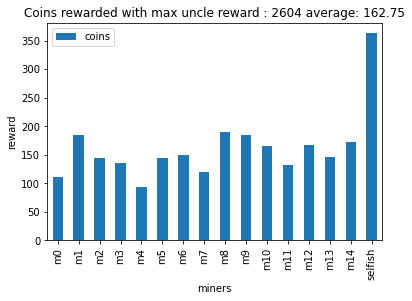

In [ ]:
BASEREWARD = 7
UNCLEREWARD = 10
NEPHEWREWARD = 3
bc = Blockchain("0", 5)
miners = []
for i in range(15):
    m = Miner(1, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(2,"selfish", bc)
while bc.size < 300:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
calculateBaseRewards(miners,bc.mainchainPrint)
calculateUncleRewards(miners, bc.uncleBlocks, bc.mainchain)
visualizeRewards(miners, "with max")


## Plotting reward over time

alpha 0.10526315789473684
[2, 2, 2, 5, 5, 2, 2, 2, 2, 2, 2]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5]
[2, 5, 2, 2, 2, 2]
[5, 5, 5, 2, 2]
[5, 5, 2, 5, 5, 2, 5, 5, 2]
[2, 2, 5, 5, 2, 2, 2]
[5, 2, 2, 2, 2, 2, 2, 5, 2, 5, 5]
[2, 2, 2, 2, 5, 5, 5, 5, 2, 5, 2, 5, 5]
[5, 2, 5, 5, 5, 5, 5, 5, 2, 2]
[5, 2, 2, 2, 2, 5, 2, 2]
[5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 5]
[2, 5, 5, 2, 5]
[5, 5, 5, 5, 5, 2, 5, 5]
[5, 2, 2, 5, 2]
[2, 5, 5, 5, 2, 2]
[2, 5, 2, 5, 5, 5, 2, 2, 5, 5, 5, 2, 5, 5, 2, 2, 2, 5, 5, 5, 5, 5, 2, 2, 5]
         coins
m0          28
m1          33
m2          15
m3          19
m4          36
m5          20
m6          34
m7          47
m8          41
m9          22
m10         49
m11         19
m12         37
m13         16
m14         21
selfish     95


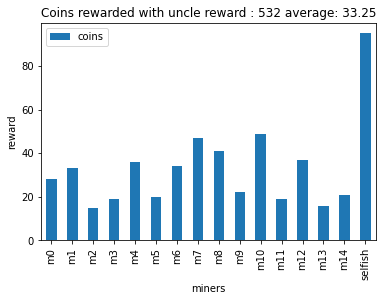

In [ ]:
BASEREWARD = 10
UNCLEREWARD = 5
NEPHEWREWARD = 2

bc = Blockchain("0", 5)
miners = []
for i in range(15):
    m = Miner(1, "m"+str(i), bc)
    miners.append(m)

selfish = SelfishMiner(2,"selfish", bc)
while bc.size < 300:
    selfish.PoWSolver()

    for m in miners: 
        m.PoWSolver()
    
    selfish.UpdateLast()
     
    for m in miners: 
        m.UpdateLast()


miners.append(selfish)
total = selfish.miningPower
for m in miners: 
    total += m.miningPower
print("alpha {}".format(selfish.miningPower/total))
bc.createMainChain()
bc.getUncles()
bc.getUnclesBlock()
calculateUncleRewards(miners, bc.uncleBlocks, bc.mainchain)
visualizeRewards(miners, "with")